# 🧠 Simple GAN on MNIST — Step by Step (Colab-ready)

**What you'll learn**
- Build a minimal GAN (Generator + Discriminator)
- Understand the non-saturating GAN loss used in practice
- Train on MNIST and visualize samples over epochs
- Stabilization tricks: label smoothing, fixed-noise evaluation, proper weight init

**Tip for Colab**: Set Runtime → *Change runtime type* → **GPU**.


In [ ]:
# ✅ (Optional) Install/upgrade PyTorch & TorchVision on Colab if needed.
# If you're already on Colab and torch is present, you can skip this cell.
import importlib, sys
try:
    import torch, torchvision
except Exception as e:
    print("Installing torch & torchvision...")
    !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
    import torch, torchvision
print(torch.__version__)


2.8.0+cu126


In [ ]:
# ⚙️ Imports & basic setup
import os, math, random
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
# 📦 Hyperparameters — tweak these to experiment
image_size = 28 * 28          # MNIST flattened
z_dim = 100                   # noise dimension
g_hidden = 256
d_hidden = 256
batch_size = 128
num_epochs = 20               # increase to 50+ for nicer digits
lr_g = 2e-4
lr_d = 2e-4
beta1, beta2 = 0.5, 0.999     # Adam betas recommended for GANs
label_smooth_real = 0.9       # one-sided label smoothing for real labels
sample_dir = Path('samples')
sample_dir.mkdir(exist_ok=True)
model_dir = Path('checkpoints')
model_dir.mkdir(exist_ok=True)
print('Samples →', sample_dir.resolve())
print('Checkpoints →', model_dir.resolve())


Samples → /content/samples
Checkpoints → /content/checkpoints


## 1) Dataset & Dataloader
We normalize MNIST to [-1, 1] to match the Generator's `tanh` output.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])

train_ds = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
len(train_ds), len(train_loader)


100%|██████████| 9.91M/9.91M [00:03<00:00, 3.29MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


(60000, 469)

## 2) Models — Minimal MLP GAN
**Why MLP first?** It's the clearest to read. DCGAN (convolutions) is great too, but this keeps the math visible.

- **Generator**: noise → hidden layers (+BatchNorm) → `tanh` image in [-1, 1]
- **Discriminator**: image → hidden layers → *logits* (we use `BCEWithLogitsLoss`, so **no sigmoid** here)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden=256, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden, hidden*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden*2),
            nn.Linear(hidden*2, img_dim),
            nn.Tanh(),  # output in [-1, 1]
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, hidden*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden*2, hidden),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden, 1)  # output logits (no sigmoid)
        )
    def forward(self, x):
        return self.net(x)

def weights_init(m):
    if isinstance(m, (nn.Linear,)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

G = Generator(z_dim=z_dim, hidden=g_hidden, img_dim=image_size).to(device)
D = Discriminator(img_dim=image_size, hidden=d_hidden).to(device)
G.apply(weights_init); D.apply(weights_init)
G, D


(Generator(
   (net): Sequential(
     (0): Linear(in_features=100, out_features=256, bias=True)
     (1): LeakyReLU(negative_slope=0.2, inplace=True)
     (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Linear(in_features=256, out_features=512, bias=True)
     (4): LeakyReLU(negative_slope=0.2, inplace=True)
     (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): Linear(in_features=512, out_features=784, bias=True)
     (7): Tanh()
   )
 ),
 Discriminator(
   (net): Sequential(
     (0): Linear(in_features=784, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2, inplace=True)
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=512, out_features=256, bias=True)
     (4): LeakyReLU(negative_slope=0.2, inplace=True)
     (5): Dropout(p=0.3, inplace=False)
     (6): Linear(in_features=256, out_features=1, bias=True)
   )
 ))

## 3) Losses & Optimizers
- **Non-saturating loss** for the Generator: minimize `BCEWithLogitsLoss(D(G(z)), 1)`
- For the Discriminator: `BCEWithLogitsLoss(D(real), 1)` and `BCEWithLogitsLoss(D(fake), 0)`
- We use **label smoothing** for real targets (0.9 instead of 1.0) to avoid overconfident D.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
opt_G = torch.optim.Adam(G.parameters(), lr=lr_g, betas=(beta1, beta2))
opt_D = torch.optim.Adam(D.parameters(), lr=lr_d, betas=(beta1, beta2))

# fixed noise for visualizing G's progress over epochs
fixed_z = torch.randn(64, z_dim, device=device)


## 4) Helper: visualize and save generated samples
We save grids every few epochs so you can see progression easily (and make a GIF if you want).

In [ ]:
def save_samples(generator, epoch, folder=sample_dir, nrow=8, with_fixed=False):
    generator.eval()
    with torch.no_grad():
        if with_fixed:
            z = fixed_z
        else:
            z = torch.randn(64, z_dim, device=device)
        fake = generator(z).view(-1, 1, 28, 28)
        grid = vutils.make_grid(fake, nrow=nrow, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.title(f'Generated samples @ epoch {epoch}')
    plt.imshow(grid.permute(1,2,0).cpu())
    out_path = folder / f'epoch_{epoch:03d}.png'
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    return out_path


## 5) Training Loop
**Order matters**: we typically update D first (on real + fake), then update G once.

For D:
- Maximize log D(x) + log(1 - D(G(z))) ↔ minimize BCE(real→1, fake→0)

For G (non-saturating):
- Maximize log D(G(z)) ↔ minimize BCE(fake→1)


In [ ]:
G.train(); D.train()
g_losses, d_losses = [], []

for epoch in range(1, num_epochs+1):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    epoch_g_loss, epoch_d_loss = 0.0, 0.0

    for real, _ in pbar:
        real = real.view(-1, image_size).to(device)
        bs = real.size(0)

        # -------------------------
        # 1) Update Discriminator
        # -------------------------
        opt_D.zero_grad()

        # Real
        real_logits = D(real)
        real_targets = torch.full((bs, 1), label_smooth_real, device=device)
        loss_D_real = criterion(real_logits, real_targets)

        # Fake (detach so gradients don't flow into G when training D)
        z = torch.randn(bs, z_dim, device=device)
        fake = G(z).detach()
        fake_logits = D(fake)
        fake_targets = torch.zeros(bs, 1, device=device)
        loss_D_fake = criterion(fake_logits, fake_targets)

        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        opt_D.step()

        # ---------------------
        # 2) Update Generator
        # ---------------------
        opt_G.zero_grad()
        z = torch.randn(bs, z_dim, device=device)
        fake = G(z)
        fake_logits = D(fake)
        # Non-saturating loss: pretend fakes are real (target=1)
        target_real_for_g = torch.ones(bs, 1, device=device)
        loss_G = criterion(fake_logits, target_real_for_g)
        loss_G.backward()
        opt_G.step()

        epoch_g_loss += loss_G.item() * bs
        epoch_d_loss += loss_D.item() * bs
        pbar.set_postfix({
            'D': f"{loss_D.item():.3f}",
            'G': f"{loss_G.item():.3f}"
        })

    # Average losses for the epoch
    epoch_g_loss /= len(train_ds)
    epoch_d_loss /= len(train_ds)
    g_losses.append(epoch_g_loss)
    d_losses.append(epoch_d_loss)

    # Save samples regularly (both fresh and fixed noise for comparability)
    if epoch == 1 or epoch % 2 == 0 or epoch == num_epochs:
        p = save_samples(G, epoch, with_fixed=True)
        print(f"Saved samples → {p}")

    # Save checkpoints periodically
    if epoch % 5 == 0 or epoch == num_epochs:
        torch.save(G.state_dict(), model_dir / f'G_epoch_{epoch:03d}.pth')
        torch.save(D.state_dict(), model_dir / f'D_epoch_{epoch:03d}.pth')

print('Training done!')


Epoch 1/20: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s, D=1.318, G=0.917]


Saved samples → samples/epoch_001.png


Epoch 2/20: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s, D=1.228, G=0.867]


Saved samples → samples/epoch_002.png


Epoch 4/20: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s, D=1.131, G=1.082]


Saved samples → samples/epoch_004.png


Epoch 6/20: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s, D=1.113, G=1.064]


Saved samples → samples/epoch_006.png


Epoch 8/20: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s, D=1.250, G=1.261]


Saved samples → samples/epoch_008.png


Epoch 10/20: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s, D=1.102, G=1.032]


Saved samples → samples/epoch_010.png


Epoch 12/20: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s, D=1.331, G=1.093]


Saved samples → samples/epoch_012.png


Epoch 14/20: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s, D=1.249, G=0.945]


Saved samples → samples/epoch_014.png


Epoch 16/20: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s, D=1.183, G=0.999]


Saved samples → samples/epoch_016.png


Epoch 18/20: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s, D=1.300, G=1.172]


Saved samples → samples/epoch_018.png


Epoch 20/20: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s, D=1.236, G=1.198]


Saved samples → samples/epoch_020.png
Training done!


## 6) Plot losses
GAN losses don't necessarily decrease monotonically — look for overall stability and sample quality.

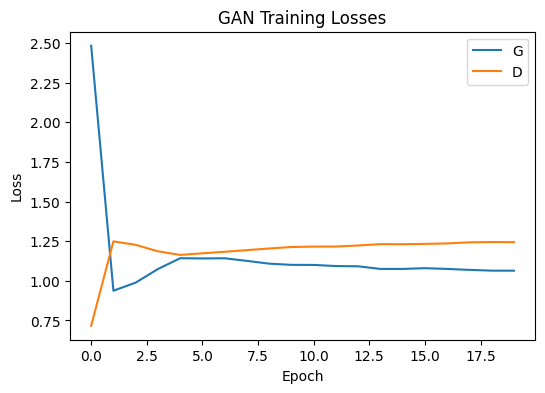

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(g_losses, label='G')
plt.plot(d_losses, label='D')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('GAN Training Losses')
plt.show()


## 7) Generate final samples (and view the latest grid)
Rerun this cell anytime after training to see fresh samples.

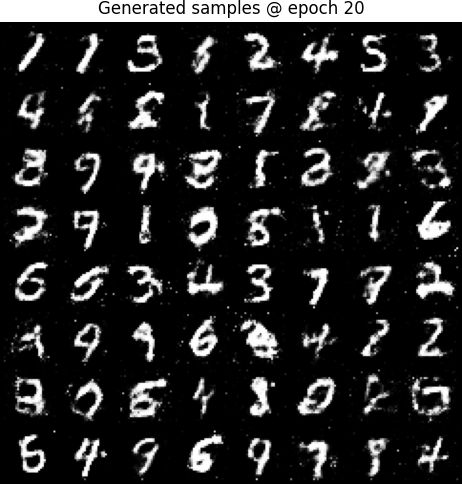

In [ ]:
_ = save_samples(G, epoch=num_epochs, with_fixed=False)
from IPython.display import Image, display
display(Image(filename=str(sample_dir / f'epoch_{num_epochs:03d}.png')))


## 8) (Optional) Make a GIF of training progress
If you saved `epoch_*.png` samples, you can stitch them into a GIF.

In [ ]:
import imageio, glob
paths = sorted(glob.glob(str(sample_dir / 'epoch_*.png')))
gif_path = sample_dir / 'progress.gif'
if paths:
    frames = [imageio.v2.imread(p) for p in paths]
    imageio.mimsave(gif_path, frames, fps=2)
    print('Saved', gif_path)
else:
    print('No sample images found to make a GIF.')


Saved samples/progress.gif


## 9) (Optional) How to load a saved model later
This lets you resume or just generate digits with a trained Generator.

In [ ]:
# Example: reload Generator and generate more digits
# G2 = Generator(z_dim=z_dim, hidden=g_hidden, img_dim=image_size).to(device)
# G2.load_state_dict(torch.load(model_dir / f'G_epoch_{num_epochs:03d}.pth', map_location=device))
# G2.eval()
# with torch.no_grad():
#     z = torch.randn(64, z_dim, device=device)
#     fake = G2(z).view(-1,1,28,28)
# grid = vutils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
# plt.figure(figsize=(6,6)); plt.axis('off'); plt.title('Reloaded G samples')
# plt.imshow(grid.permute(1,2,0).cpu()); plt.show()


In [ ]:
from google.colab import files
files.download("samples/progress.gif")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

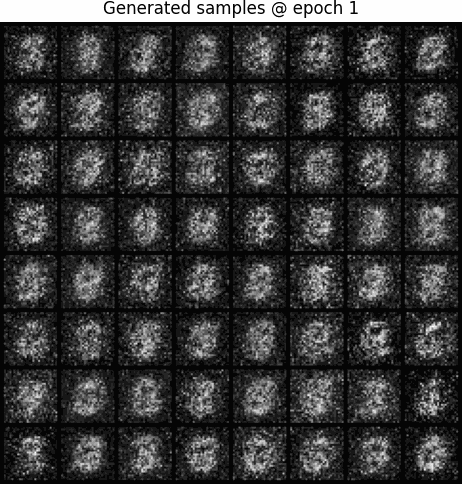

In [ ]:
from IPython.display import Image
Image(filename="samples/progress.gif")


---
### Where to go next
- Swap MLP for **DCGAN** (convolutional) layers
- Try **Spectral Normalization** for D
- Replace loss with **Wasserstein** + **Gradient Penalty** (WGAN-GP)
- Add **minibatch discrimination** or **feature matching** to fight mode collapse
